In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed,SimpleRNN,Dropout,GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_excel("D:\\Projects\\BDA\\aircraft_reliability\\data\\PM_train.xlsx")
df_truth = pd.read_excel("D:\\Projects\\BDA\\aircraft_reliability\\data\\PM_truth.xlsx")


In [3]:
df_merged = pd.merge(df, df_truth, on='id')
df_merged

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,more
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190,98
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236,98
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442,98
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739,98
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20426,99,181,-0.0015,-0.0001,100,518.67,643.72,1600.39,1428.03,14.62,...,2388.29,8123.55,8.4885,0.03,396,2388,100,38.50,23.0425,20
20427,99,182,-0.0027,-0.0003,100,518.67,643.52,1605.33,1430.32,14.62,...,2388.27,8130.99,8.5124,0.03,393,2388,100,38.39,22.9674,20
20428,99,183,-0.0031,-0.0003,100,518.67,643.96,1606.95,1427.90,14.62,...,2388.31,8126.90,8.5374,0.03,395,2388,100,38.57,23.1440,20
20429,99,184,-0.0010,-0.0001,100,518.67,644.10,1600.20,1436.54,14.62,...,2388.33,8125.66,8.5592,0.03,395,2388,100,38.45,23.0478,20


In [4]:
# Step 1: Get the maximum cycle for each engine
max_cycle_per_engine = df.groupby('id')['cycle'].max().reset_index()
max_cycle_per_engine.columns = ['id', 'max_cycle']

# Step 2: Merge the maximum cycle with the df_truth to get the actual failure cycle
df_merged = pd.merge(max_cycle_per_engine, df_truth, on='id')

# Step 3: Calculate the actual failure cycle (when engine will fail)
df_merged['failure_cycle'] = df_merged['max_cycle'] + df_merged['more']

# Step 4: Merge this back with the main DataFrame to compute remaining cycles
df = pd.merge(df, df_merged[['id', 'failure_cycle']], on='id')

# Step 5: Calculate remaining cycles for each row by subtracting the current cycle from the failure cycle
df['remaining_cycles'] = df['failure_cycle'] - df['cycle']
df = df.drop('failure_cycle',axis=1)

In [5]:
df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,remaining_cycles
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190,289
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236,288
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442,287
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739,286
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044,285


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20431 entries, 0 to 20430
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                20431 non-null  int64  
 1   cycle             20431 non-null  int64  
 2   setting1          20431 non-null  float64
 3   setting2          20431 non-null  float64
 4   setting3          20431 non-null  int64  
 5   s1                20431 non-null  float64
 6   s2                20431 non-null  float64
 7   s3                20431 non-null  float64
 8   s4                20431 non-null  float64
 9   s5                20431 non-null  float64
 10  s6                20431 non-null  float64
 11  s7                20431 non-null  float64
 12  s8                20431 non-null  float64
 13  s9                20431 non-null  float64
 14  s10               20431 non-null  float64
 15  s11               20431 non-null  float64
 16  s12               20431 non-null  float6

In [6]:
# Assuming `df` is the provided DataFrame
# Split engines into train and test ensuring no overlap of engine IDs
engine_ids = df['id'].unique()
train_ids, test_ids = train_test_split(engine_ids, test_size=0.3, random_state=0)
train_ids,val_ids = train_test_split(train_ids, test_size=0.2, random_state=0)
# Create train and test sets
train_df = df[df['id'].isin(train_ids)].reset_index(drop=True)
test_df = df[df['id'].isin(test_ids)].reset_index(drop=True)
val_df = df[df['id'].isin(val_ids)].reset_index(drop=True)


In [7]:
def create_sequences_2(df, window_size=50):
    X_row_seq, y_row_seq = [], []
    X_window_seq, y_window_seq = [], []
    
    for engine_id, group in df.groupby('id'):
        # Ensure the group is sorted by cycle
        group = group.sort_values('cycle')
        
        # Row-wise sequence (single cycle for each row)
        for _, row in group.iterrows():
            # Append each row as a sequence of length 1 for the single-cycle model
            X_row_seq.append(row[['setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, 22)]].values)
            y_row_seq.append(row['remaining_cycles'])
        
        # Sliding window sequence for windowed model
        for start in range(len(group) - window_size + 1):
            end = start + window_size
            sequence = group.iloc[start:end]
            X_window_seq.append(sequence[['setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, 22)]].values)
            y_window_seq.append(sequence['remaining_cycles'].values[-1])  # Target: RUL of the last cycle in window

    # Convert lists to numpy arrays and reshape for compatibility with RNNs
    X_row_seq = np.array(X_row_seq).reshape(-1, 1, len(X_row_seq[0]))  # Shape: (num_rows, 1, num_features)
    y_row_seq = np.array(y_row_seq)
    X_window_seq = np.array(X_window_seq)  # Shape: (num_windows, window_size, num_features)
    y_window_seq = np.array(y_window_seq)

    # Debugging output to verify shapes
    print(f"Shape of X_row_seq: {X_row_seq.shape}")  # Expected: (num_rows, 1, num_features)
    print(f"Shape of y_row_seq: {y_row_seq.shape}")  # Expected: (num_rows,)
    print(f"Shape of X_window_seq: {X_window_seq.shape}")  # Expected: (num_windows, window_size, num_features)
    print(f"Shape of y_window_seq: {y_window_seq.shape}")  # Expected: (num_windows,)

    return X_row_seq, y_row_seq, X_window_seq, y_window_seq

In [8]:
window_size=3

In [9]:
xtrain_single, ytrain_single, xtrain_window, ytrain_window = create_sequences_2(train_df,window_size=window_size)

Shape of X_row_seq: (11354, 1, 24)
Shape of y_row_seq: (11354,)
Shape of X_window_seq: (11244, 3, 24)
Shape of y_window_seq: (11244,)


In [10]:
xtest_single,ytest_single,xtest_window,ytest_window = create_sequences_2(test_df,window_size=window_size)

Shape of X_row_seq: (6356, 1, 24)
Shape of y_row_seq: (6356,)
Shape of X_window_seq: (6296, 3, 24)
Shape of y_window_seq: (6296,)


In [11]:
xval_single,yval_single,xval_window,yval_window = create_sequences_2(val_df,window_size=window_size)

Shape of X_row_seq: (2721, 1, 24)
Shape of y_row_seq: (2721,)
Shape of X_window_seq: (2693, 3, 24)
Shape of y_window_seq: (2693,)


In [12]:
#train test val of single

num_features = xtrain_single.shape[2]
scaler = StandardScaler()
Xtrain_reshaped = xtrain_single.reshape(-1, num_features)
X_train_scaled = scaler.fit_transform(Xtrain_reshaped)
Xtrain_scaled_single = X_train_scaled.reshape(xtrain_single.shape)

X_test_reshaped = xtest_single.reshape(-1, num_features)
X_test_scaled = scaler.transform(X_test_reshaped)  # Only transform on test data
Xtest_scaled_single = X_test_scaled.reshape(xtest_single.shape)

X_val_reshaped = xval_single.reshape(-1, num_features)
X_val_scaled = scaler.transform(X_val_reshaped)  # Only transform on test data
Xval_scaled_single = X_val_scaled.reshape(xval_single.shape)


In [13]:
#train test val of window

scaler = StandardScaler()
Xtrain_reshaped = xtrain_window.reshape(-1, num_features)
X_train_scaled = scaler.fit_transform(Xtrain_reshaped)
Xtrain_scaled_window = X_train_scaled.reshape(xtrain_window.shape)

X_test_reshaped = xtest_window.reshape(-1, num_features)
X_test_scaled = scaler.transform(X_test_reshaped)  # Only transform on test data
Xtest_scaled_window = X_test_scaled.reshape(xtest_window.shape)

X_val_reshaped = xval_window.reshape(-1, num_features)
X_val_scaled = scaler.transform(X_val_reshaped)  # Only transform on test data
Xval_scaled_window = X_val_scaled.reshape(xval_window.shape)

In [14]:
# Count the number of unique engines in train and test sets
num_train_engines = train_df['id'].nunique()
num_test_engines = test_df['id'].nunique()

print(f"Number of engines in training set: {num_train_engines}")
print(f"Number of engines in test set: {num_test_engines}")

# Sum the cycles per engine
train_cycles_per_engine = train_df.groupby('id').size()
test_cycles_per_engine = test_df.groupby('id').size()

print(f"Total cycles in training set: {train_cycles_per_engine.sum()}")
print(f"Total cycles in test set: {test_cycles_per_engine.sum()}")

# Optional: Check average cycles per engine
print(f"Average cycles per engine in training set: {train_cycles_per_engine.mean()}")
print(f"Average cycles per engine in test set: {test_cycles_per_engine.mean()}")


Number of engines in training set: 55
Number of engines in test set: 30
Total cycles in training set: 11354
Total cycles in test set: 6356
Average cycles per engine in training set: 206.43636363636364
Average cycles per engine in test set: 211.86666666666667


In [15]:
single_model = Sequential([
    SimpleRNN(128, input_shape=(1, num_features), activation='relu'),
    Dense(16, activation='relu'),  # Fully connected layer for feature extraction
    Dense(1)  # Output layer (RUL prediction)
])
single_model.compile(optimizer=Adam(learning_rate=0.001),loss='mse')

In [16]:
# Train the model
single_history = single_model.fit(Xtrain_scaled_single, ytrain_single,
                    validation_data=(Xval_scaled_single, yval_single),
                    epochs=200, batch_size=64,
                    callbacks=tf.keras.callbacks.EarlyStopping(patience=20,monitor='val_loss'))

Epoch 1/200
178/178 [==============================] - 2s 5ms/step - loss: 30608.4707 - val_loss: 11410.0801
Epoch 2/200
178/178 [==============================] - 1s 4ms/step - loss: 10656.7783 - val_loss: 8823.3633
Epoch 3/200
178/178 [==============================] - 1s 5ms/step - loss: 6387.7998 - val_loss: 6486.5210
Epoch 4/200
178/178 [==============================] - 1s 4ms/step - loss: 4676.1011 - val_loss: 5818.9932
Epoch 5/200
178/178 [==============================] - 1s 4ms/step - loss: 4164.7822 - val_loss: 5618.7852
Epoch 6/200
178/178 [==============================] - 1s 4ms/step - loss: 3974.0930 - val_loss: 5275.7476
Epoch 7/200
178/178 [==============================] - 1s 4ms/step - loss: 3893.6829 - val_loss: 5429.4648
Epoch 8/200
178/178 [==============================] - 1s 4ms/step - loss: 3848.9517 - val_loss: 5204.8164
Epoch 9/200
178/178 [==============================] - 1s 4ms/step - loss: 3803.0630 - val_loss: 5377.2310
Epoch 10/200
178/178 [============

In [17]:
window_model = Sequential([
    SimpleRNN(128, input_shape=(window_size, num_features), activation='relu'),  # LSTM layer for window-level sequences
    Dense(16, activation='relu'),  # Fully connected layer
    Dense(1)  # Output layer (RUL prediction)
])

window_model.compile(optimizer=Adam(learning_rate=0.001),loss='mse')

In [18]:
# Train the model
window_history = window_model.fit(Xtrain_scaled_window, ytrain_window,
                                  validation_data=(Xval_scaled_window, yval_window),
                    epochs=200, batch_size=64,
                    callbacks=tf.keras.callbacks.EarlyStopping(patience=20,monitor='val_loss'))

Epoch 1/200
176/176 [==============================] - 2s 6ms/step - loss: 11989.9238 - val_loss: 6092.5449
Epoch 2/200
176/176 [==============================] - 1s 4ms/step - loss: 4124.6050 - val_loss: 5391.8555
Epoch 3/200
176/176 [==============================] - 1s 4ms/step - loss: 3891.9480 - val_loss: 5187.3828
Epoch 4/200
176/176 [==============================] - 1s 4ms/step - loss: 3771.1921 - val_loss: 5774.3467
Epoch 5/200
176/176 [==============================] - 1s 5ms/step - loss: 3680.0444 - val_loss: 5067.1440
Epoch 6/200
176/176 [==============================] - 1s 4ms/step - loss: 3663.7368 - val_loss: 5298.1230
Epoch 7/200
176/176 [==============================] - 1s 4ms/step - loss: 3615.7161 - val_loss: 5113.0674
Epoch 8/200
176/176 [==============================] - 1s 4ms/step - loss: 3599.3279 - val_loss: 6092.1465
Epoch 9/200
176/176 [==============================] - 1s 5ms/step - loss: 3588.9509 - val_loss: 5382.1646
Epoch 10/200
176/176 [==============

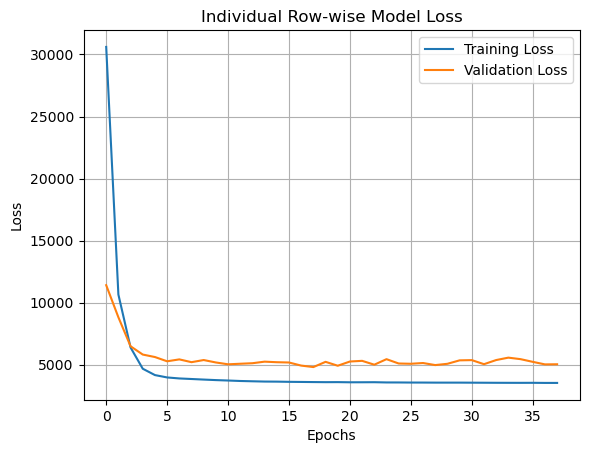

In [19]:
# Plotting function
def plot_loss(history, title,lim=(None,None)):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.ylim(lim)
    plt.grid(True)
    plt.show()

# Plot for individual row-wise model
plot_loss(single_history, 'Individual Row-wise Model Loss')


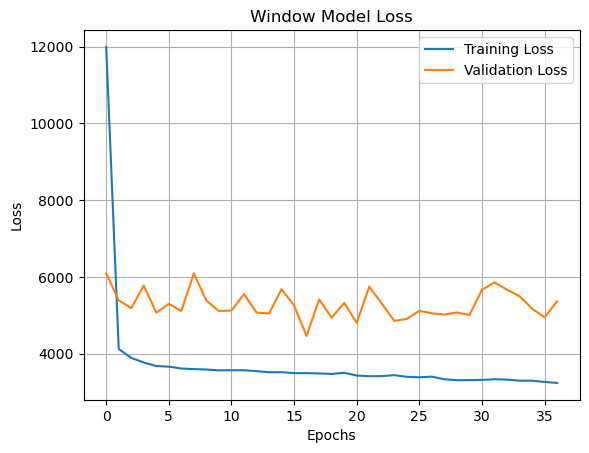

In [20]:
plot_loss(window_history,'Window Model Loss',)

In [21]:
# Adjusted evaluation function
def evaluate_model(model, X_test, y_test,type):
    predictions = model.predict(X_test)
    if predictions.shape[0] != y_test.shape[0]:
        # Trimming to the minimum size for consistency
        min_len = min(predictions.shape[0], y_test.shape[0])
        predictions = predictions[:min_len]
        y_test = y_test[:min_len]
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    print(f"{type} Model Evaluation - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    return predictions, rmse, mae

In [22]:
def get_combined_predictions(pred_single, pred_window):
    """
    Combines predictions from single-model and window-model predictions.

    Args:
        pred_single (np.array): Predictions from the single-model.
        pred_window (np.array): Predictions from the window-model.

    Returns:
        combined_predictions (np.array): Averaged predictions.
    """
    # Ensure the predictions are reshaped to (n_samples, 1) for averaging
    pred_single = np.array(pred_single).reshape(-1, 1)
    pred_window = np.array(pred_window).reshape(-1, 1)
    
    # Average the predictions
    combined_predictions = (pred_single + pred_window) / 2
    return combined_predictions

In [23]:
# Now update the combined evaluation to use trimmed predictions
def evaluate_combined_model(pred_single, pred_window, y_test):
    # Trim both predictions and y_test to the minimum shared length
    min_len = min(len(pred_single), len(pred_window), len(y_test))
    pred_single, pred_window, y_test = pred_single[:min_len], pred_window[:min_len], y_test[:min_len]

    # Get combined predictions
    combined_predictions = (pred_single + pred_window) / 2
    rmse = np.sqrt(mean_squared_error(y_test, combined_predictions))
    mae = mean_absolute_error(y_test, combined_predictions)
    print(f"Combined Model Evaluation - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    return combined_predictions, rmse, mae

In [24]:
# Get predictions and evaluate each model individually
pred_single, rmse_single, mae_single = evaluate_model(single_model, Xtest_scaled_single, ytest_single,'single')
pred_window, rmse_window, mae_window = evaluate_model(window_model, Xtest_scaled_window, ytest_window,'window')

# Evaluate combined predictions
combined_predictions, rmse_combined, mae_combined = evaluate_combined_model(pred_single, pred_window, ytest_single)


199/199 [==============================] - 1s 2ms/step
single Model Evaluation - RMSE: 60.69, MAE: 47.88
197/197 [==============================] - 1s 2ms/step
window Model Evaluation - RMSE: 62.49, MAE: 49.12
Combined Model Evaluation - RMSE: 63.87, MAE: 51.21


In [25]:
Xtest_scaled_window.shape

(6296, 3, 24)

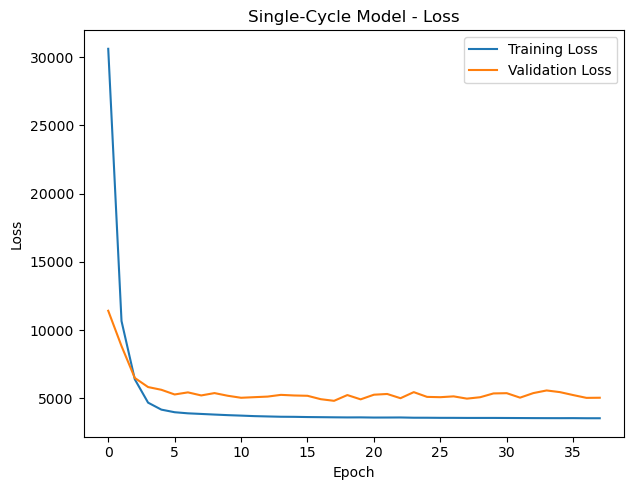

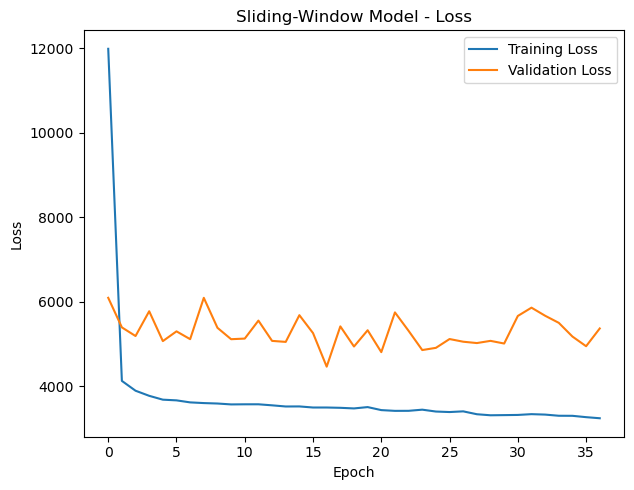

In [26]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name="Model"):
    """
    Plots the training and validation loss and metric (e.g., RMSE) for each epoch.
    
    Parameters:
    - history: History object from model training.
    - model_name: Name of the model for labeling the plot.
    """
    # Plot loss
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training & validation RMSE/MAE values if available
    if 'rmse' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['rmse'], label='Training RMSE')
        plt.plot(history.history['val_rmse'], label='Validation RMSE')
        plt.title(f'{model_name} - RMSE')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.legend()
    
    elif 'mae' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title(f'{model_name} - MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_training_history(single_history, model_name="Single-Cycle Model")
plot_training_history(window_history, model_name="Sliding-Window Model")


199/199 [==============================] - 0s 2ms/step


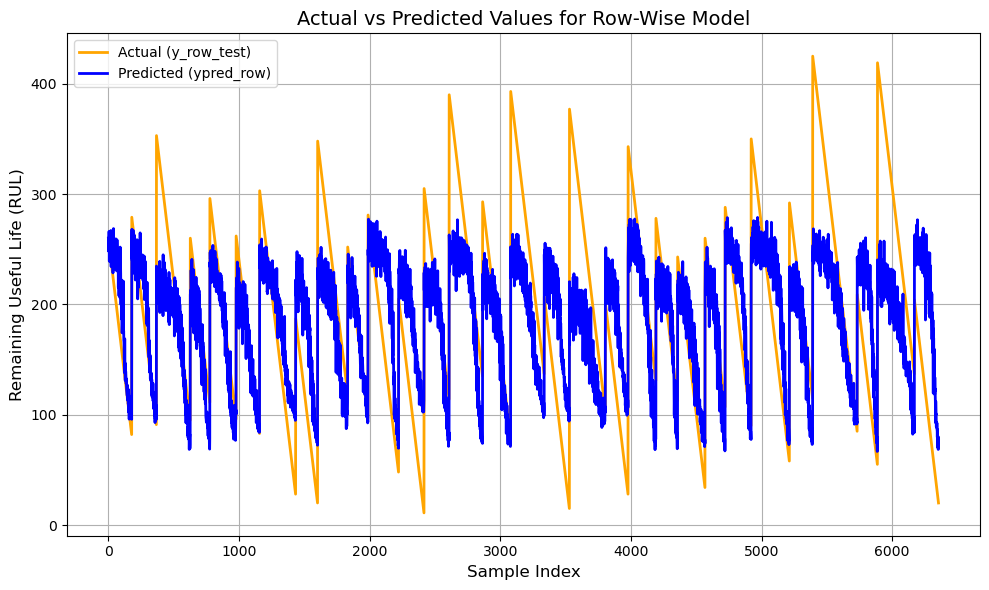

In [27]:
import matplotlib.pyplot as plt

ypred_row = single_model.predict(Xtest_scaled_single)

# Assuming y_row_test and ypred_row are already defined as numpy arrays
# y_row_test: Actual values (true labels for the row-wise test data)
# ypred_row: Predicted values from the row-wise model

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(ytest_single, color='orange', label='Actual (y_row_test)', linewidth=2)  # Orange line for actual values
plt.plot(ypred_row, color='blue', label='Predicted (ypred_row)', linewidth=2)  # Blue dashed line for predicted values

# Adding titles and labels
plt.title('Actual vs Predicted Values for Row-Wise Model', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Remaining Useful Life (RUL)', fontsize=12)
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
import matplotlib.pyplot as plt

ypred_window = window_model.predict(Xtest_scaled_window)

# Assuming y_row_test and ypred_row are already defined as numpy arrays
# y_row_test: Actual values (true labels for the row-wise test data)
# ypred_row: Predicted values from the row-wise model

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6),dpi=1200)
plt.plot(ytest_window, color='orange', label='Actual (y_row_test)', linewidth=2)  # Orange line for actual values
plt.plot(ypred_window, color='blue', label='Predicted (ypred_row)', linewidth=1)  # Blue dashed line for predicted values

# Adding titles and labels
plt.title('Actual vs Predicted Values for Row-Wise Model', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Remaining Useful Life (RUL)', fontsize=12)
plt.legend()

# Show the plot
plt.grid(True)
# plt.tight_layout()
plt.show()


197/197 [==============================] - 0s 2ms/step
